<a href="https://colab.research.google.com/github/AtSourav/AE-n-VAE-with-CB-loss-on-stl10/blob/main/AE_cifar10_mse_HeNormal_L.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow import math
import tensorflow_datasets as tfds
from keras import losses
from keras import layers
from keras import utils
from keras import backend as K
from keras import initializers

import os
import random
import matplotlib.pyplot as plt

In [5]:
img_ht = 32
img_wd = 32

input_size = (img_ht,img_wd,3)
latent_dim = 256
batch_size = 128

initializer = initializers.HeNormal(seed=100)
#inititalizer = initializers.TruncatedNormal()

In [3]:
ds = tfds.load('cifar10', split='train')
ds2= tfds.load('cifar10', split='test')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteTFD0RL/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteTFD0RL/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [4]:
ds_to_np = list(ds.as_numpy_iterator())
ds2_to_np = list(ds2.as_numpy_iterator())

In [6]:
img_train = np.array([x['image'] for x in ds_to_np])
img_valid = np.array([x['image'] for x in ds2_to_np])

img_train = img_train/255
img_valid = img_valid/255

In [7]:
encoder_input = keras.Input(shape=input_size)

x = layers.Conv2D(64, 2, padding="valid", kernel_initializer=initializer)(encoder_input)
x = layers.ReLU()(x)

x = layers.Conv2D(64, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

#x = layers.Conv2D(64, 1, padding="valid", kernel_initializer=initializer)(x)
#x = layers.ReLU()(x)

x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")(x)

x = layers.Conv2D(128, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(128, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(128, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

#x = layers.Conv2D(128, 1, padding="valid", kernel_initializer=initializer)(x)
#x = layers.ReLU()(x)

x = layers.Conv2D(256, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(256, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(256, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(256, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

#x = layers.Conv2D(256, 1, padding="valid", kernel_initializer=initializer)(x)
#x = layers.ReLU()(x)

#x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")(x)
#x = layers.ReLU()(x)


x = layers.Conv2D(512, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(512, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.BatchNormalization(axis=-1)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(512, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.BatchNormalization(axis=-1)(x)
x = layers.ReLU()(x)

#x = layers.Conv2D(512, 1, padding="valid", kernel_initializer=initializer)(x)
#x = layers.ReLU()(x)

x = layers.Conv2D(1024, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(1024, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.BatchNormalization(axis=-1)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(1024, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

#x = layers.Conv2D(1024, 1, padding="valid", kernel_initializer=initializer)(x)
#x = layers.ReLU()(x)

#x = layers.MaxPooling2D(pool_size=(2, 2), strides=1, padding="valid")(x)

x = layers.Flatten()(x)

#x = layers.Dense(8*latent_dim)(x)
#x = layers.ReLU()(x)

x = layers.Dense(4*latent_dim)(x)
x = layers.ReLU()(x)

x = layers.Dense(2*latent_dim)(x)
x = layers.ReLU()(x)


z = layers.Dense(latent_dim, name="z")(x)

encoder = keras.Model(encoder_input, z, name='encoder')
encoder.summary()



Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 31, 31, 64)        832       
                                                                 
 re_lu (ReLU)                (None, 31, 31, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 64)        16448     
                                                                 
 re_lu_1 (ReLU)              (None, 30, 30, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 64)        0         
 D)                                                              
                                                           

In [8]:
latent_input = keras.Input(shape=(latent_dim,))

x = layers.Dense(2*latent_dim)(latent_input)
x = layers.ReLU()(x)

x = layers.Dense(4*latent_dim)(x)
x = layers.ReLU()(x)

x = layers.Dense(8*latent_dim)(x)
x = layers.ReLU()(x)

x = layers.Dense(16*latent_dim)(x)
x = layers.ReLU()(x)

x = layers.Reshape((2,2,1024))(x)

#x = layers.Conv2DTranspose(1024, 1, padding='valid', kernel_initializer=initializer)(x)
#x = layers.ReLU()(x)

x = layers.Conv2DTranspose(1024, 2, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(1024, 2, padding='valid', kernel_initializer=initializer)(x)
x = layers.BatchNormalization(axis=-1)(x)
x = layers.ReLU()(x)

#x = layers.Conv2DTranspose(512, 1, padding='valid', kernel_initializer=initializer)(x)
#x = layers.ReLU()(x)

x = layers.Conv2DTranspose(512, 2, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(512, 2, padding='valid', kernel_initializer=initializer)(x)
x = layers.BatchNormalization(axis=-1)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(512, 2, padding='valid', kernel_initializer=initializer)(x)
x = layers.BatchNormalization(axis=-1)(x)
x = layers.ReLU()(x)

#x = layers.Conv2DTranspose(256, 1, padding='valid', kernel_initializer=initializer)(x)
#x = layers.ReLU()(x)

x = layers.Conv2DTranspose(256, 2, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(256, 2, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(256, 2, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(256, 2, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

#x = layers.Conv2DTranspose(128, 1, padding='valid', kernel_initializer=initializer)(x)
#x = layers.ReLU()(x)

x = layers.Conv2DTranspose(128, 2, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(128, 2, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(128, 2, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(128, 2, strides=2, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(128, 2, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

#x = layers.Conv2DTranspose(64, 1, padding='valid', kernel_initializer=initializer)(x)
#x = layers.ReLU()(x)

x = layers.Conv2DTranspose(64, 2, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(64, 2, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

decoder_output = layers.Conv2DTranspose(3, 2, activation='sigmoid', padding='valid', kernel_initializer=initializer)(x)

decoder = keras.Model(latent_input, decoder_output, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256)]             0         
                                                                 
 dense_2 (Dense)             (None, 512)               131584    
                                                                 
 re_lu_17 (ReLU)             (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 1024)              525312    
                                                                 
 re_lu_18 (ReLU)             (None, 1024)              0         
                                                                 
 dense_4 (Dense)             (None, 2048)              2099200   
                                                                 
 re_lu_19 (ReLU)             (None, 2048)              0   

In [9]:
decoder_out = decoder(encoder(encoder_input))
AE = keras.Model(encoder_input, decoder_out, name='AE')

AE.summary()

Model: "AE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 encoder (Functional)        (None, 256)               19071488  
                                                                 
 decoder (Functional)        (None, 32, 32, 3)         25499139  
                                                                 
Total params: 44570627 (170.02 MB)
Trainable params: 44562435 (169.99 MB)
Non-trainable params: 8192 (32.00 KB)
_________________________________________________________________


In [ ]:
K.clear_session()

In [10]:
#lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=200, decay_rate=0.995)
optim = keras.optimizers.Adam(learning_rate = 0.01)                  # clipnorm=2.0
AE.compile(optimizer=optim,loss='mse')

In [11]:
history = AE.fit(img_train, img_train, batch_size=4*batch_size, validation_data=(img_valid, img_valid), epochs=5, steps_per_epoch=None)

Epoch 1/5
98/98 [==============================] - 150s 1s/step - loss: 0.0736 - val_loss: 0.0529
Epoch 2/5
98/98 [==============================] - 71s 720ms/step - loss: 0.0482 - val_loss: 0.1026
Epoch 3/5
98/98 [==============================] - 70s 720ms/step - loss: 0.0444 - val_loss: 0.0789
Epoch 4/5
98/98 [==============================] - 70s 718ms/step - loss: 0.0435 - val_loss: 0.1983
Epoch 5/5
98/98 [==============================] - 70s 719ms/step - loss: 0.0432 - val_loss: 0.0578


In [12]:
optim = keras.optimizers.Adam(learning_rate = 0.0075)                  # clipnorm=2.0
AE.compile(optimizer=optim,loss='mse')

In [13]:
history2 = AE.fit(img_train, img_train, batch_size=4*batch_size, validation_data=(img_valid, img_valid), epochs=5, steps_per_epoch=None)

Epoch 1/5
98/98 [==============================] - 84s 733ms/step - loss: 0.0441 - val_loss: 0.0493
Epoch 2/5
98/98 [==============================] - 70s 717ms/step - loss: 0.0425 - val_loss: 0.2102
Epoch 3/5
98/98 [==============================] - 70s 716ms/step - loss: 0.0423 - val_loss: 0.0506
Epoch 4/5
98/98 [==============================] - 70s 717ms/step - loss: 0.0420 - val_loss: 0.2235
Epoch 5/5
98/98 [==============================] - 70s 718ms/step - loss: 0.0420 - val_loss: 0.2189


In [14]:
optim = keras.optimizers.Adam(learning_rate = 0.0025)                  # clipnorm=2.0
AE.compile(optimizer=optim,loss='mse')
history3 = AE.fit(img_train, img_train, batch_size=8*batch_size, validation_data=(img_valid, img_valid), epochs=5, steps_per_epoch=None)        # increasing the minibatch size in a bid to stabilise the learning

Epoch 1/5
49/49 [==============================] - 201s 3s/step - loss: 0.0412 - val_loss: 0.0505
Epoch 2/5
49/49 [==============================] - 71s 1s/step - loss: 0.0406 - val_loss: 0.0528
Epoch 3/5
49/49 [==============================] - 70s 1s/step - loss: 0.0404 - val_loss: 0.0582
Epoch 4/5
49/49 [==============================] - 70s 1s/step - loss: 0.0406 - val_loss: 0.0545
Epoch 5/5
49/49 [==============================] - 70s 1s/step - loss: 0.0405 - val_loss: 0.0521


In [15]:
optim = keras.optimizers.Adam(learning_rate = 0.0001)                  # clipnorm=2.0
AE.compile(optimizer=optim,loss='mse')
history4 = AE.fit(img_train, img_train, batch_size=8*batch_size, validation_data=(img_valid, img_valid), epochs=5, steps_per_epoch=None)

Epoch 1/5
49/49 [==============================] - 84s 1s/step - loss: 0.0403 - val_loss: 0.0448
Epoch 2/5
49/49 [==============================] - 70s 1s/step - loss: 0.0402 - val_loss: 0.0429
Epoch 3/5
49/49 [==============================] - 70s 1s/step - loss: 0.0401 - val_loss: 0.0423
Epoch 4/5
49/49 [==============================] - 70s 1s/step - loss: 0.0401 - val_loss: 0.0413
Epoch 5/5
49/49 [==============================] - 70s 1s/step - loss: 0.0401 - val_loss: 0.0409


In [16]:
optim = keras.optimizers.Adam(learning_rate = 0.000075)                  # clipnorm=2.0
AE.compile(optimizer=optim,loss='mse')
history5 = AE.fit(img_train, img_train, batch_size=8*batch_size, validation_data=(img_valid, img_valid), epochs=5, steps_per_epoch=None)

Epoch 1/5
49/49 [==============================] - 83s 1s/step - loss: 0.0400 - val_loss: 0.0407
Epoch 2/5
49/49 [==============================] - 70s 1s/step - loss: 0.0399 - val_loss: 0.0407
Epoch 3/5
49/49 [==============================] - 70s 1s/step - loss: 0.0399 - val_loss: 0.0402
Epoch 4/5
49/49 [==============================] - 70s 1s/step - loss: 0.0399 - val_loss: 0.0405
Epoch 5/5
49/49 [==============================] - 70s 1s/step - loss: 0.0399 - val_loss: 0.0402


In [17]:
optim = keras.optimizers.Adam(learning_rate = 0.000025)                  # clipnorm=2.0
AE.compile(optimizer=optim,loss='mse')
history6 = AE.fit(img_train, img_train, batch_size=8*batch_size, validation_data=(img_valid, img_valid), epochs=5, steps_per_epoch=None)

Epoch 1/5
49/49 [==============================] - 82s 1s/step - loss: 0.0399 - val_loss: 0.0400
Epoch 2/5
49/49 [==============================] - 70s 1s/step - loss: 0.0399 - val_loss: 0.0399
Epoch 3/5
49/49 [==============================] - 70s 1s/step - loss: 0.0399 - val_loss: 0.0399
Epoch 4/5
49/49 [==============================] - 70s 1s/step - loss: 0.0399 - val_loss: 0.0399
Epoch 5/5
49/49 [==============================] - 70s 1s/step - loss: 0.0398 - val_loss: 0.0399


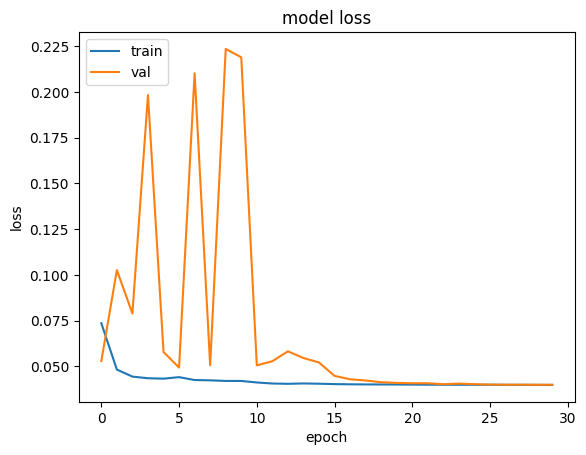

In [18]:
plt.plot(history.history['loss']+history2.history['loss']+history3.history['loss']+history4.history['loss']+history5.history['loss']+history6.history['loss'])
plt.plot(history.history['val_loss']+history2.history['val_loss']+history3.history['val_loss']+history4.history['val_loss']+history5.history['val_loss']+history6.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [19]:
def plot_reconstruction(set, name,seed_val, epochs):     #name should be either 'training' or 'validation'
  np.random.seed(seed_val)

  tg_indices = np.random.randint(0,set.shape[0],size = 16)
  img_sample = tf.convert_to_tensor(np.array(set)[tg_indices])
  z_sample = encoder(img_sample)
  img_recon = decoder(z_sample)

  recon = plt.figure(figsize=(9,4))    # it's weird that the order of axes in figsize is the opposite to that in add_subplot
  recon.suptitle('Reconstructed images (right) from the ' + name + '-set after ' + str(epochs) + ' epochs: no regularisation in the encoder, decoder, latent_dim = 512', fontweight= 'bold', y=0.93)

  recon.tight_layout()

  for i in range(36):
    recon.add_subplot(4,9,i+1)
    j = int(np.floor(i/9))
    if (i%9) <4:
      img = set[tg_indices[j*4 + (i%9)]]
      plt.imshow(img)
      plt.axis('off')
    elif (i%9)==4:
      img = np.ones((32,32,3))
      plt.imshow(img)
      plt.axis('off')
    else:
      img = img_recon[j*4 + (i%9) - 5]
      plt.imshow(img)
      plt.axis('off')

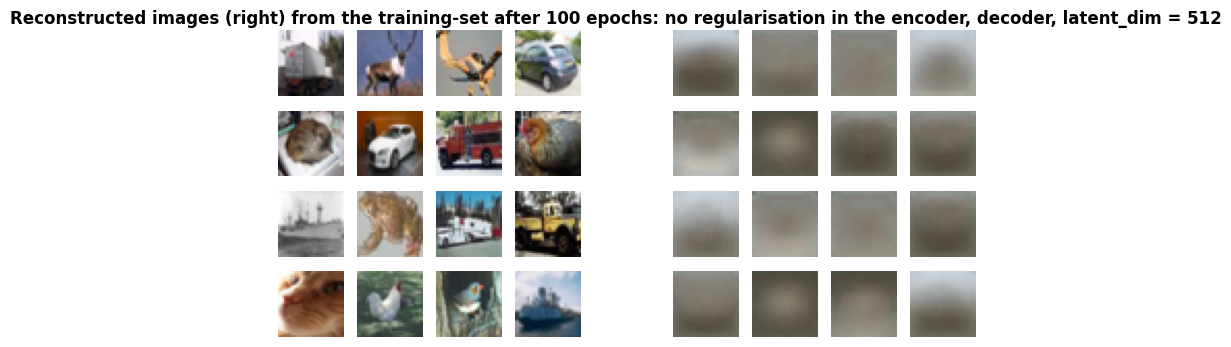

In [20]:
plot_reconstruction(img_train, 'training', 123, 100)

In [ ]:
optim = keras.optimizers.Adam(learning_rate = 0.007)                  # clipnorm=2.0
AE.compile(optimizer=optim,loss='mse')
history7 = AE.fit(img_train, img_train, batch_size=8*batch_size, validation_data=(img_valid, img_valid), epochs=3, steps_per_epoch=None)

Epoch 1/3
54/54 [==============================] - 93s 1s/step - loss: 0.0457 - val_loss: 0.1077
Epoch 2/3
54/54 [==============================] - 78s 1s/step - loss: 0.0425 - val_loss: 0.1101
Epoch 3/3
54/54 [==============================] - 78s 1s/step - loss: 0.0424 - val_loss: 0.0689


In [ ]:
optim = keras.optimizers.Adam(learning_rate = 0.0025)                  # clipnorm=2.0
AE.compile(optimizer=optim,loss='mse')
history8 = AE.fit(img_train, img_train, batch_size=8*batch_size, validation_data=(img_valid, img_valid), epochs=5, steps_per_epoch=None)

NameError: ignored